## This notebook is to build a model for Titanic competition in Kaggle

In [6]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [7]:
# import te data
path = 'data/'
# path = '/media/ahmed-zaki/8860127C60127164/Programming/Python/ML/Projects/My Projects/Titanic/data/'

train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

In [8]:
%pwd

'/workspaces/ML_Projects/my_projects/Titanic'

In [9]:
train_df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [10]:
train_df.shape

(891, 12)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


we see that there are some missing values and categorical features we have to deal with

In [12]:
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [13]:
test_df.nunique()

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

In [14]:
train_df['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Text(0.5, 1.0, 'Survived Feature Distribution')

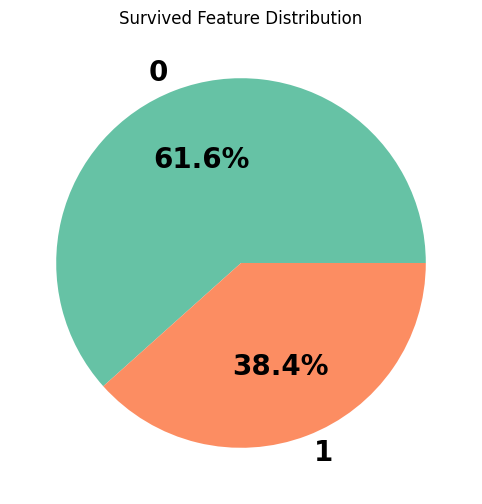

In [15]:
plt.figure(figsize=(10,6))
plt.pie(train_df["Survived"].value_counts(),labels=train_df["Survived"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Survived Feature Distribution")


In [16]:
cat_cols = ["Pclass","Sex","Embarked","SibSp","Parch"]

def cat_plot(df):
    plt.figure(figsize=(12,20))
    for idx,column in enumerate(cat_cols):
        plt.subplot(5,1,idx+1)
        sns.countplot(x=column, hue="Survived", data=df, palette="Set2")
        plt.title(f"{column} Distribution")
        plt.tight_layout()

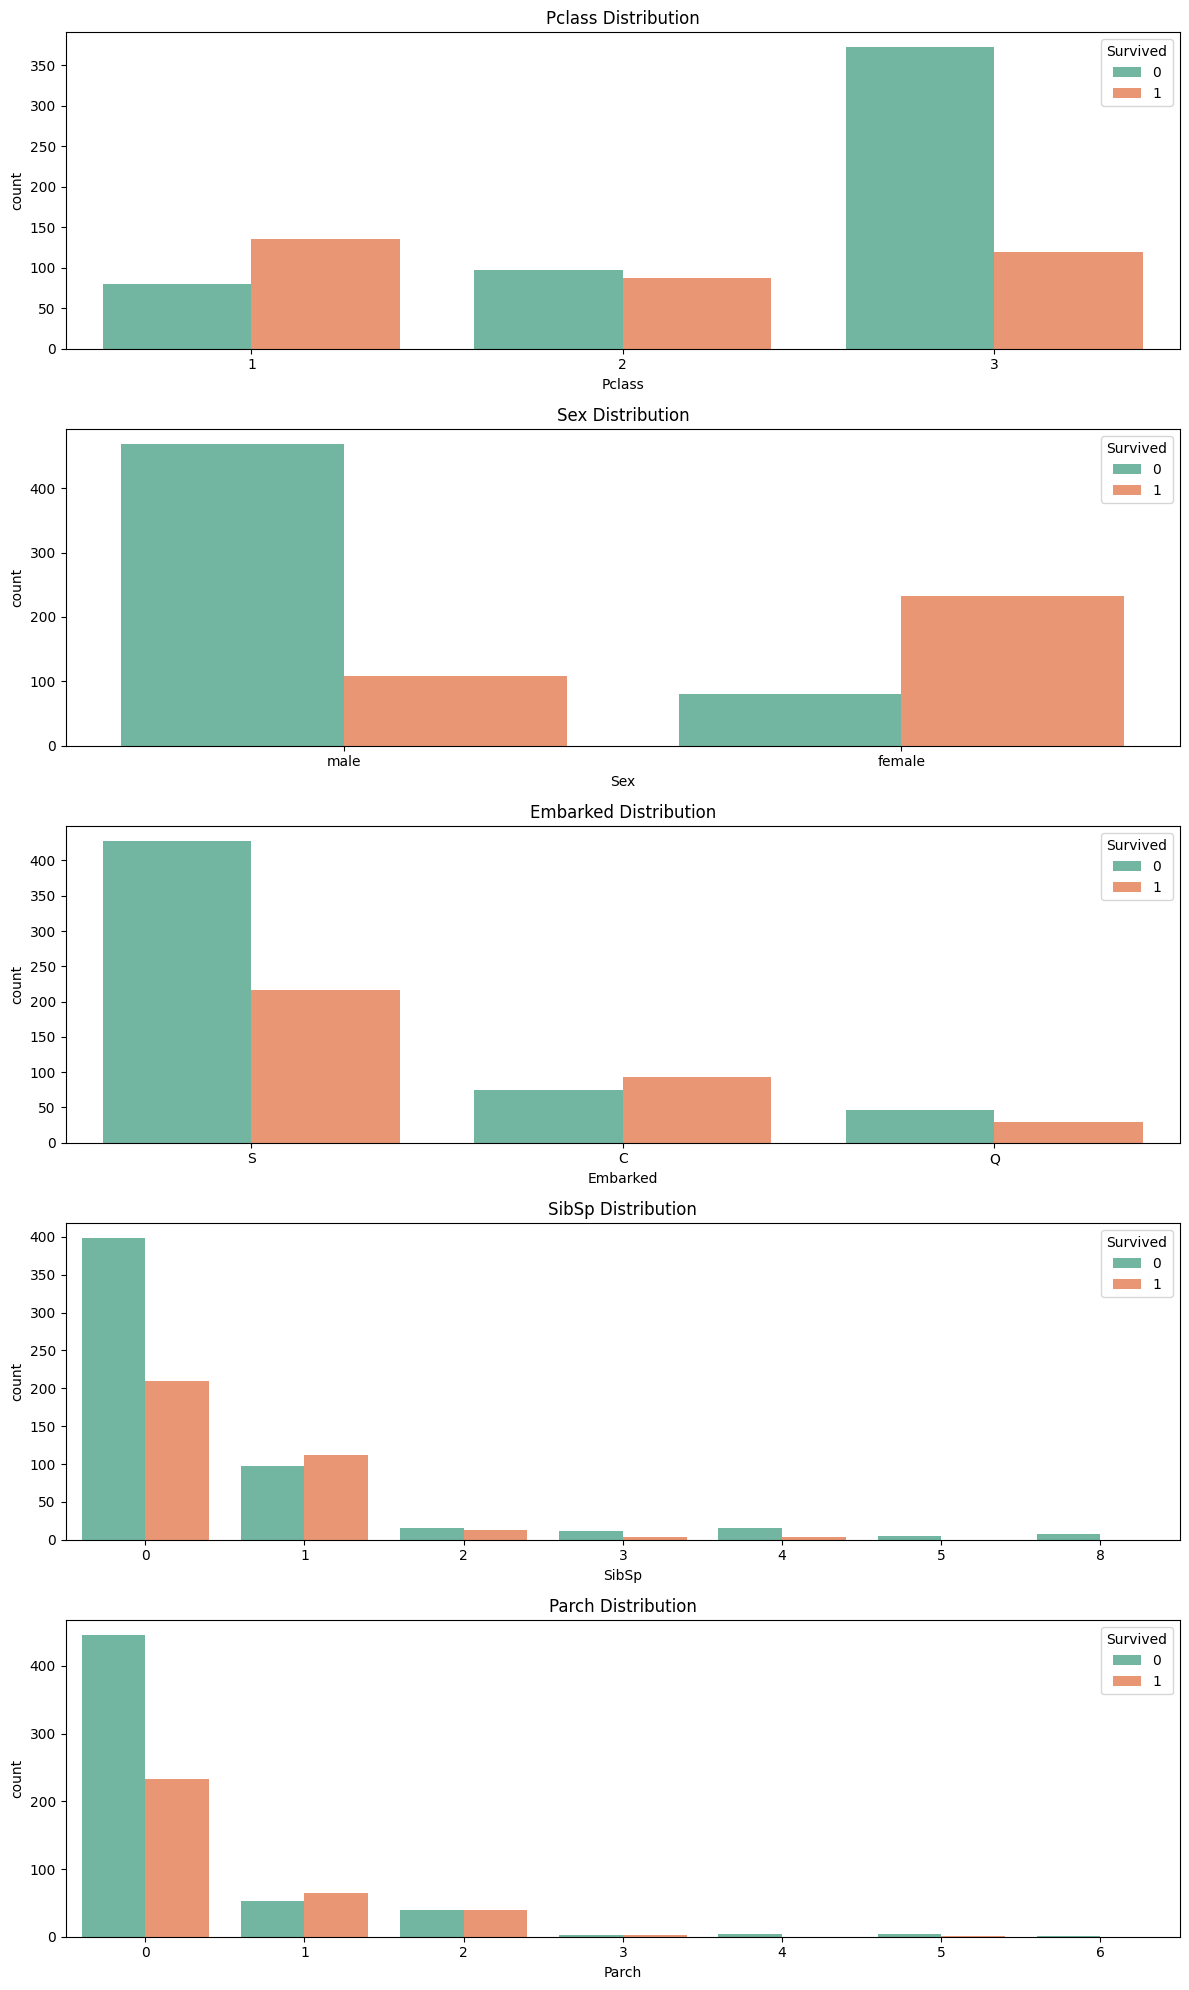

In [17]:
cat_plot(train_df)

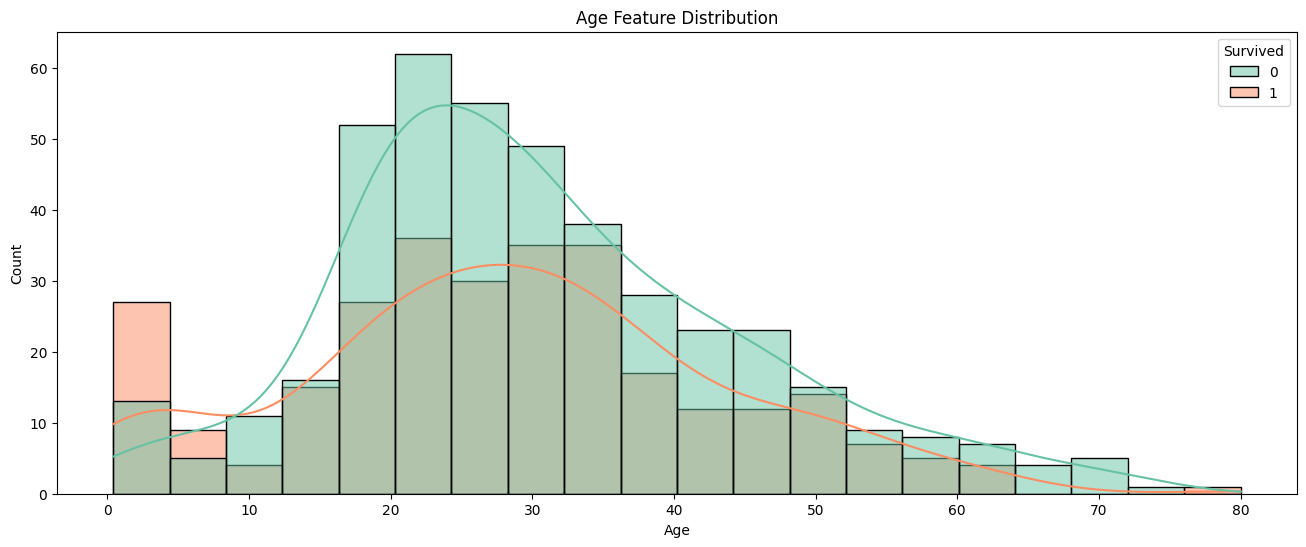

In [18]:
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Survived",data=train_df,kde=True,palette="Set2")
plt.title("Age Feature Distribution");

In [19]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_13-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("age_50+")
        else:
            age_group.append("age_unknown")
        
    df["Age Group"] = age_group
    df.drop('Age',axis=1, inplace = True)

In [20]:
age_group(train_df)
age_group(test_df)

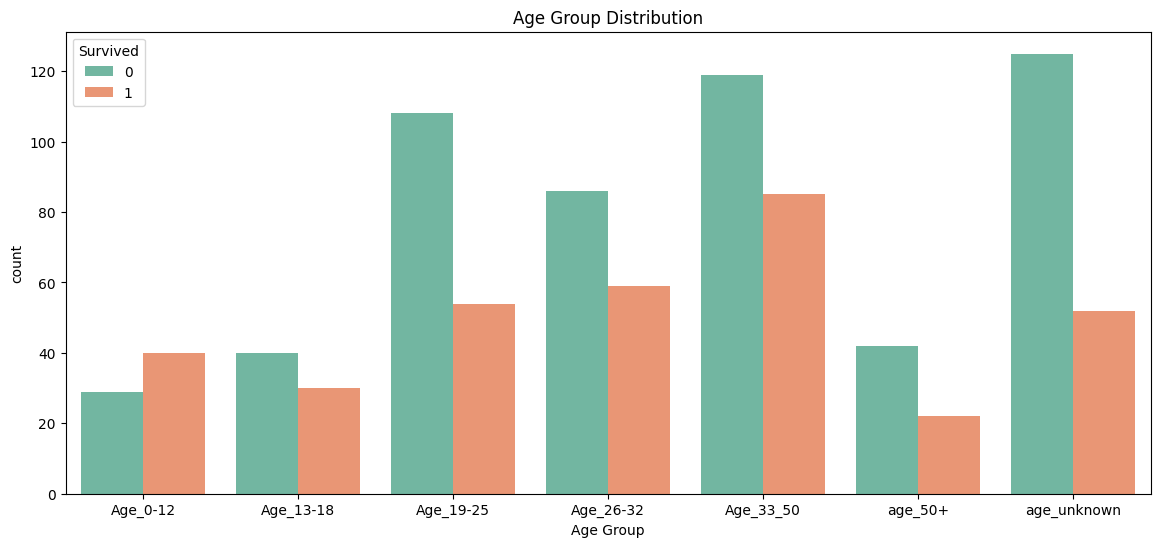

In [21]:
order = sorted(train_df["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Survived", data=train_df, palette="Set2",order=order)
plt.title("Age Group Distribution");

In [22]:
def came_alone_feature(df):
        df['came_alone'] = (df['Parch'] + df['SibSp'] == 0).astype(int)

In [23]:
came_alone_feature(train_df)
train_df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,came_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,Age_19-25,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,Age_33_50,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,Age_26-32,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,Age_33_50,0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,Age_33_50,1
5,6,0,3,"Moran, Mr. James",male,0,0,330877,8.4583,NaN,Q,age_unknown,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,0,0,17463,51.8625,E46,S,age_50+,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,3,1,349909,21.0750,NaN,S,Age_0-12,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,0,2,347742,11.1333,NaN,S,Age_26-32,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,1,0,237736,30.0708,NaN,C,Age_13-18,0


In [24]:
came_alone_feature(test_df)
test_df.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Group,came_alone
0,892,3,"Kelly, Mr. James",male,0,0,330911,7.8292,NaN,Q,Age_33_50,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,1,0,363272,7.0000,NaN,S,Age_33_50,0
2,894,2,"Myles, Mr. Thomas Francis",male,0,0,240276,9.6875,NaN,Q,age_50+,1
3,895,3,"Wirz, Mr. Albert",male,0,0,315154,8.6625,NaN,S,Age_26-32,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,3101298,12.2875,NaN,S,Age_19-25,0


In [25]:
train_df.duplicated().sum()


0

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  Age Group    418 non-null    object 
 11  came_alone   418 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 39.3+ KB


In [27]:
test_df.shape

(418, 12)

In [28]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

Cabin       687
Embarked      2
dtype: int64

In [29]:
test_df.isnull().sum()[test_df.isnull().sum() > 0]

Fare       1
Cabin    327
dtype: int64

In [30]:
train_df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1,inplace=True)


In [31]:
PassengerId = test_df['PassengerId']

In [32]:
test_df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1,inplace=True)

In [33]:
train_df['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [34]:
train_df['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [35]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
SibSp         0
Parch         0
Fare          0
Embarked      2
Age Group     0
came_alone    0
dtype: int64

In [36]:
test_df.isnull().sum()

Pclass        0
Sex           0
SibSp         0
Parch         0
Fare          1
Embarked      0
Age Group     0
came_alone    0
dtype: int64

In [37]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy='mean')
imputed_train = my_imputer.fit_transform(train_df[[ 'Fare']])
imputed_test = my_imputer.transform(test_df[['Fare']])

train_df[[ 'Fare']] = imputed_train
test_df[[ 'Fare']] = imputed_test

In [38]:
train_df.loc[train_df['Embarked'].isna()] = train_df.loc[train_df['Embarked'].isna()].fillna(value ={'Embarked':'S'})

In [39]:
train_df.loc[train_df['Embarked'].isna()]

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group,came_alone


In [40]:
train_df['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [41]:
train_df.head(20)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Group,came_alone
0,0,3,male,1,0,7.2500,S,Age_19-25,0
1,1,1,female,1,0,71.2833,C,Age_33_50,0
2,1,3,female,0,0,7.9250,S,Age_26-32,1
3,1,1,female,1,0,53.1000,S,Age_33_50,0
4,0,3,male,0,0,8.0500,S,Age_33_50,1
5,0,3,male,0,0,8.4583,Q,age_unknown,1
6,0,1,male,0,0,51.8625,S,age_50+,1
7,0,3,male,3,1,21.0750,S,Age_0-12,0
8,1,3,female,0,2,11.1333,S,Age_26-32,0
9,1,2,female,1,0,30.0708,C,Age_13-18,0


In [42]:
def get_dummies_func(df):
    df = pd.get_dummies(data=df,columns=['Sex','Embarked','Age Group'],dtype=int)
    return df
train_df = get_dummies_func(train_df)
test_df =  get_dummies_func(test_df)

In [43]:
X = train_df.drop('Survived',axis=1)
y= train_df['Survived']

In [44]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,  train_size=0.8,test_size=0.2)

In [45]:
X_train.head()

,Pclass,SibSp,Parch,Fare,came_alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age Group_Age_0-12,Age Group_Age_13-18,Age Group_Age_19-25,Age Group_Age_26-32,Age Group_Age_33_50,Age Group_age_50+,Age Group_age_unknown
228,2,0,0,13.0000,1,0,1,0,0,1,0,1,0,0,0,0,0
43,2,1,2,41.5792,0,1,0,1,0,0,1,0,0,0,0,0,0
318,1,0,2,164.8667,0,1,0,0,0,1,0,0,0,1,0,0,0
839,1,0,0,29.7000,1,0,1,1,0,0,0,0,0,0,0,0,1
372,3,0,0,8.0500,1,0,1,0,0,1,0,0,1,0,0,0,0


In [46]:
model = XGBClassifier()
model.fit(X_train,y_train)
preds = model.predict(X_valid)
score = accuracy_score(y_valid,preds)
score

0.8435754189944135

In [47]:
rf_classifier = RandomForestClassifier(random_state=0,n_jobs=-1)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300,500,1000], 
    'max_depth': [None, 10, 20,30,50,100],  
    'min_samples_split': [2, 5, 10,15,20],  
    'min_samples_leaf': [1, 2, 4,6,10] 
}

# Create a StratifiedKFold cross-validation object
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the Grid Search object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)

# Perform the Grid Search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Train the Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params,random_state=0, n_jobs=-1)
best_rf_classifier.fit(X_train, y_train)
best_preds = best_rf_classifier.predict(X_valid)
print('The best parameters\' model score is : ',accuracy_score(y_valid,best_preds))

KeyboardInterrupt: 

In [48]:
# the first submission to the titanic competition and then I will improve the model

model.fit(X,y)
final_preds = model.predict(test_df)
submission = pd.DataFrame(PassengerId)
submission['Survived'] = final_preds
submission = submission.set_index('PassengerId')
submission.head()

submission.to_csv('titanic_submission3.csv')
